## **Implementation of Convolutional Neural Network (CNN)**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import torchvision
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score

import random
import zipfile
import os
from tqdm import tqdm
from tqdm.notebook import tqdm
import itertools
from PIL import Image
from PIL import ImageOps
from tabulate import tabulate

import time
import cv2
import gc
import PIL
from collections import OrderedDict

import platform
import psutil
import glob

## **Load and Prepare Dataset**

In [2]:
# Define the data directory (adjust to your dataset structure)
data_dir = "/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image"

# Verify file structure
for dirname, _, filenames in os.walk("/kaggle/input/gastric-cancer-data"):
    for filename in filenames[:]:  # limit output to avoid spam
        print(os.path.join(dirname, filename))

# Gather file paths and labels
file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

# Create DataFrame
df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the dataset

# Display sample
df

/kaggle/input/gastric-cancer-data/HMU-GC-Clinical.csv
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_2940.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3357.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3294.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3050.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3119.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3133.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_2937.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3743.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_1592.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_332.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_1810.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_2896.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K

file_path label
0      /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   STR
1      /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   TUM
2      /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   LYM
3      /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   MUS
4      /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   ADI
...                                                  ...   ...
31091  /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   MUS
31092  /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   MUC
31093  /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   STR
31094  /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   TUM
31095  /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   NOR

[31096 rows x 2 columns]

## **Visualize Class Distribution**


Class: STR, Count: 3887
Class: TUM, Count: 3887
Class: LYM, Count: 3887
Class: MUS, Count: 3887
Class: ADI, Count: 3887
Class: NOR, Count: 3887
Class: DEB, Count: 3887
Class: MUC, Count: 3887


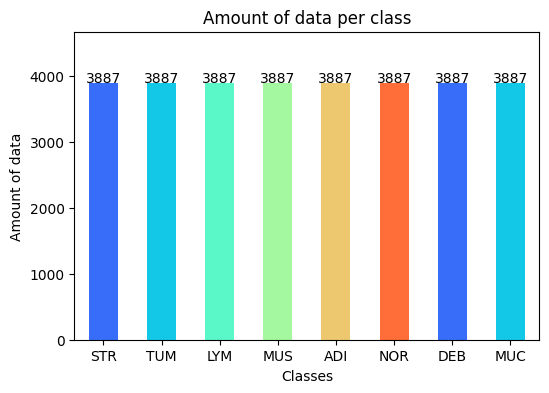

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps

class_counts_train = df['label'].value_counts()
for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_train.plot(kind='bar', color=sns.color_palette('rainbow'))
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
plt.title('Amount of data per class')

for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

## **Random Image Visualization**

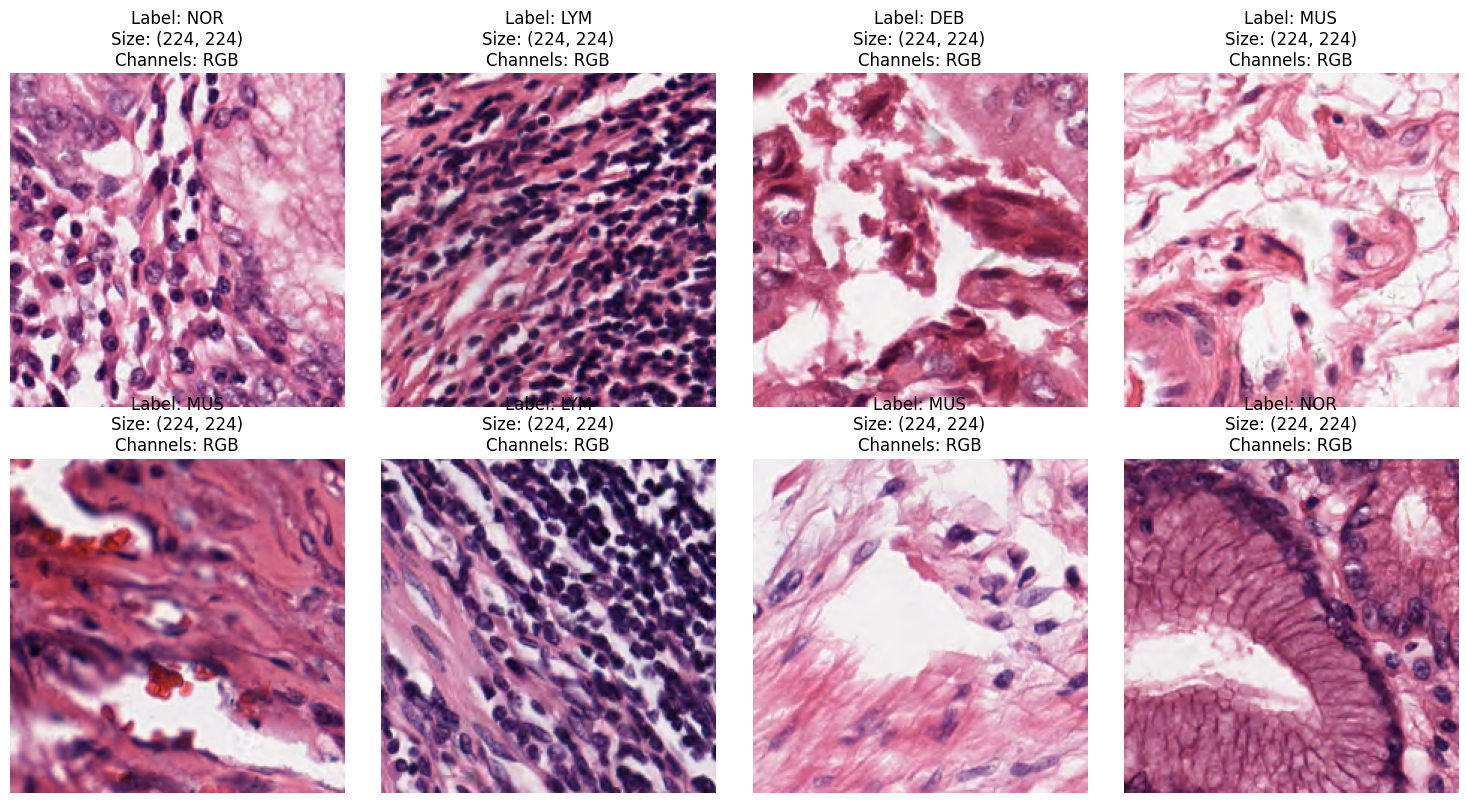

In [4]:
import random

num_images_to_show = 8
rows = 2
cols = 4
plt.figure(figsize=(15, 8))

for i in range(num_images_to_show):
    random_index = random.randint(1, len(df) - 1)
    random_row = df.iloc[random_index]
    file_path = random_row['file_path']
    label = random_row['label']
    image = Image.open(file_path)
    size = image.size
    channels = 'Grayscale' if image.mode == 'L' else 'RGB'

    plt.subplot(rows, cols, i + 1)  # Create subplots for each image
    plt.title(f"Label: {label}\nSize: {size}\nChannels: {channels}")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Split the Dataset into Training, Validation and Test set**

In [5]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
test_dataframe, valid_dataframe = train_test_split(temp_dataframe, test_size=0.5, stratify=temp_dataframe['label'], random_state=42)

In [6]:
print("Training Data (80%) :", len(train_dataframe))
print("Validation Data : ", len(valid_dataframe))
print("Test Data : ", len(test_dataframe))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data (80%) : 24876
Validation Data :  3110
Test Data :  3110
-------------------------------------------
Total amounts of data in the dataset:  31096


**Device Configuration**

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
print(f"Device : {device}")

Device : cuda


### **Dataset Class, Dataloader and Transform**

In [9]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        # Always convert labels to integers, regardless of is_lb
        self.is_lb = True
        self.label_map = {'ADI': 0, 'DEB': 1, 'LYM': 2, 'MUC': 3, 'MUS': 4, 'NOR': 5, 'STR': 6, 'TUM': 7}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)
        image = image.convert('RGB')
        # Convert label to integer using label_map
        label = self.label_map[self.dataframe.iloc[index]['label']]

        # Check if label is within the valid range and convert to LongTensor
        if not 0 <= label < 8:
            print(f"Warning: Invalid label value: {label} at index {index}, Image Path: {img_path}")
            label = 0  # Or handle the invalid label in another way

        # Ensure the image is of the correct data type
        image = self.normalize(image).type(torch.FloatTensor)

        return image, torch.tensor(label, dtype=torch.long) # Convert label to LongTensor

In [10]:
batch = 32

def data_transfrom():
    normalize = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_dataframe,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

**Custom Pooling Layer**

## **Design and Implementation of CNN model**

## **Model Training**

In [11]:
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512) # The input size to this layer should match the output size of the previous layers.
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 8)  # 8 output classes to match the number of classes in your dataset.

        # Dropout layer (to prevent overfitting)
        self.dropout = nn.Dropout(0.5) # contorl 50% on or off

    def forward(self, x):
        # First convolutional block
        x = self.pool(F.relu(self.conv1(x)))

        # Second convolutional block
        x = self.pool(F.relu(self.conv2(x)))

        # Third convolutional block
        x = self.pool(F.relu(self.conv3(x)))

        # Print the shape of x before flattening for debugging
        print("Shape of x before flattening:", x.shape)

        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 28 * 28) # Ensure this matches the output size of the convolutional layers.

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [12]:
model = CNN_model()
model = model.to(device)
print(model.parameters)
criterion = nn.CrossEntropyLoss() # Find Wrong
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)

<bound method Module.parameters of CNN_model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=8, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)>


In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`

    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): # itertools is now accessible
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Data transforms for training and validation

In [14]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
}

In [15]:
data_dir = "/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image"

image_datasets = {
    x: datasets.ImageFolder(data_dir, transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

### **List of pretrained models to experiment with**

In [16]:
pretrained_models = {
    #'resnet152': models.resnet18(pretrained=True),
    #'resnet50': models.resnet50(pretrained=True),
    #'efficientnet_b6': models.efficientnet_b6(pretrained=True)
    'DenseNet201': models.densenet201(pretrained=True),
    #'efficientnet_b3': models.efficientnet_b3(pretrained=True),
    #'MobileNet_v2': models.mobilenet_v2(pretrained=True)
}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 182MB/s]


In [17]:
num_classes = len(class_names)
print(f"Number of classes:{num_classes}")
num_epochs = 35  # Adjust as needed

Number of classes:8


In [18]:
def train_and_evaluate_model(model, model_name):
    # Modify final layer according to the architecture
    if model_name.startswith('DenseNet'):
        num_ftrs = model.classifier.in_features  # Use 'classifier' instead of 'fc'
        model.classifier = nn.Linear(num_ftrs, num_classes)  # Replace 'fc' with 'classifier'
    elif 'efficientnet' in model_name:
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    print(f"\nTraining model: {model_name}")

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Clear CUDA cache after each epoch or phase
            torch.cuda.empty_cache()
            gc.collect()

    # After training, evaluate on the validation set:
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []  # to store probabilities for ROC curve

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds) # Assign the confusion matrix to cm
    #print(cm)

    plot_confusion_matrix(cm, classes=class_names, title=f'Confusion Matrix for {model_name}')
    # ROC curve for each class (One-vs-Rest)
    fpr = {}
    tpr = {}
    roc_auc = {}
    # Binarize the output labels for multi-class ROC computation
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))

    plt.figure()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i],
                 label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

### **Loop through each pretrained model, train and evaluate**


Training model: DenseNet201
Epoch 1/35
Train Loss: 1.0966 Acc: 0.5896
Val Loss: 0.7224 Acc: 0.7244
Epoch 2/35
Train Loss: 0.9263 Acc: 0.6530
Val Loss: 0.6818 Acc: 0.7426
Epoch 3/35
Train Loss: 0.8690 Acc: 0.6715
Val Loss: 0.6691 Acc: 0.7400
Epoch 4/35
Train Loss: 0.8375 Acc: 0.6857
Val Loss: 0.5440 Acc: 0.7963
Epoch 5/35
Train Loss: 0.8025 Acc: 0.6965
Val Loss: 0.5309 Acc: 0.7994
Epoch 6/35
Train Loss: 0.7865 Acc: 0.7047
Val Loss: 0.4852 Acc: 0.8185
Epoch 7/35
Train Loss: 0.7604 Acc: 0.7150
Val Loss: 0.4956 Acc: 0.8094
Epoch 8/35
Train Loss: 0.7382 Acc: 0.7241
Val Loss: 0.4656 Acc: 0.8228
Epoch 9/35
Train Loss: 0.7294 Acc: 0.7282
Val Loss: 0.4188 Acc: 0.8465
Epoch 10/35
Train Loss: 0.7070 Acc: 0.7366
Val Loss: 0.3960 Acc: 0.8565
Epoch 11/35
Train Loss: 0.6951 Acc: 0.7417
Val Loss: 0.3747 Acc: 0.8614
Epoch 12/35
Train Loss: 0.6753 Acc: 0.7483
Val Loss: 0.3391 Acc: 0.8786
Epoch 13/35
Train Loss: 0.6484 Acc: 0.7610
Val Loss: 0.3038 Acc: 0.8922
Epoch 14/35
Train Loss: 0.6336 Acc: 0.7648
V

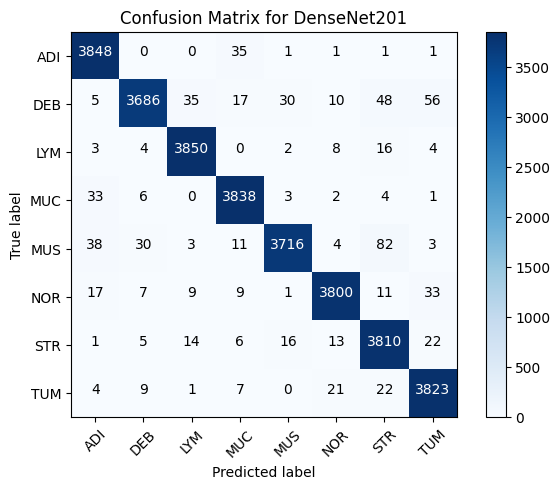

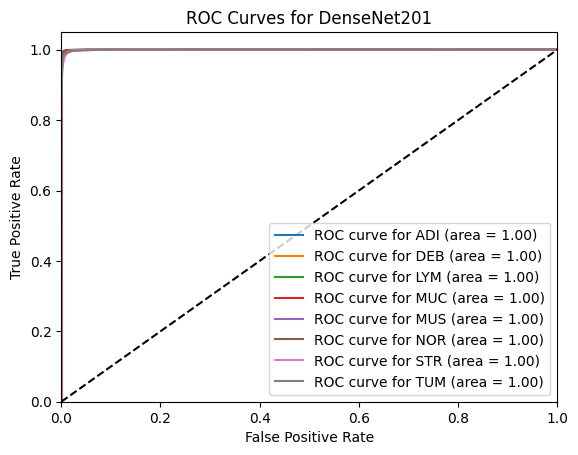

In [19]:
for name, model in pretrained_models.items():
    train_and_evaluate_model(model, name)

In [20]:
"""def get_model(model_name, num_classes):
    if model_name == 'resnet152v2':
        model = timm.create_model('resnet152d', pretrained=True)
        in_features = model.get_classifier().in_features
        model.fc = nn.Linear(in_features, num_classes)

    elif model_name == 'efficientnetv2_s':
        model = timm.create_model('efficientnetv2_s', pretrained=True)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)

    elif model_name == 'efficientnetb7':
        model = timm.create_model('efficientnet_b7', pretrained=False)
        in_features = model.get_classifier().in_features
        model.classifier = nn.Linear(in_features, num_classes)

    elif model_name == 'inceptionresnetv2':
        model = timm.create_model('inception_resnet_v2', pretrained=True)
        in_features = model.classif.in_features
        model.classif = nn.Linear(in_features, num_classes)

    else:
        raise ValueError(f"Unsupported model: {model_name}")

    return model

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def train_and_evaluate_model(model, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    print(f"\nTraining model: {model_name}")
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Evaluation
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, classes=class_names, title=f'Confusion Matrix for {model_name}')

    # ROC curve
    fpr = {}
    tpr = {}
    roc_auc = {}
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))

    plt.figure()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name}')
    plt.legend(loc="lower right")
    plt.show()
"""

'def get_model(model_name, num_classes):\n    if model_name == \'resnet152v2\':\n        model = timm.create_model(\'resnet152d\', pretrained=True)\n        in_features = model.get_classifier().in_features\n        model.fc = nn.Linear(in_features, num_classes)\n\n    elif model_name == \'efficientnetv2_s\':\n        model = timm.create_model(\'efficientnetv2_s\', pretrained=True)\n        in_features = model.classifier.in_features\n        model.classifier = nn.Linear(in_features, num_classes)\n\n    elif model_name == \'efficientnetb7\':\n        model = timm.create_model(\'efficientnet_b7\', pretrained=False)\n        in_features = model.get_classifier().in_features\n        model.classifier = nn.Linear(in_features, num_classes)\n\n    elif model_name == \'inceptionresnetv2\':\n        model = timm.create_model(\'inception_resnet_v2\', pretrained=True)\n        in_features = model.classif.in_features\n        model.classif = nn.Linear(in_features, num_classes)\n\n    else:\n        

**Some Models**

In [21]:
"""top_models = [
    'efficientnetb7'
]

for model_name in top_models:
    model = get_model(model_name, num_classes)
    train_and_evaluate_model(model, model_name)
"""

"top_models = [\n    'efficientnetb7'\n]\n\nfor model_name in top_models:\n    model = get_model(model_name, num_classes)\n    train_and_evaluate_model(model, model_name)\n"